In [1]:
import os
import json
from itertools import combinations
import numpy as np
import pandas as pd
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from collections import Counter
import matplotlib.pyplot as plt

def filter_overlap_results(overlap_results, alpha=0.05):
    """
    对 overlap_results 中的双向 p 值取最大值，并进行 BH 校正

    返回值:
        筛选后显著的 overlap 列表（FDR ≤ alpha）
    """

    # 合并 p 值（取最大值）
    raw_pvals = [max(res['pval_1to2'], res['pval_2to1']) for res in overlap_results]
    
    # Benjamini-Hochberg FDR 校正
    rejected, pvals_corrected, _, _ = multipletests(raw_pvals, alpha=alpha, method='fdr_bh')

    # 添加原始和校正后的 p 值（不添加 significant 字段）
    for i, res in enumerate(overlap_results):
        res['raw_pval'] = raw_pvals[i]
        res['fdr_adj_pval'] = pvals_corrected[i]
        
    # 返回显著的结果（根据 rejected 数组筛选）
    sig_results = [res for i, res in enumerate(overlap_results) if rejected[i]]

    print(f"{len(sig_results)} pairs passed BH correction at FDR ≤ {alpha}")
    return sig_results


In [2]:
# Step 1: 构建知识库
# knowledge_base = {}
# counter = 1

# base_dir = 'regress'
# for trait_name in os.listdir(base_dir):
#     trait_path = os.path.join(base_dir, trait_name)
#     if os.path.isdir(trait_path):
#         for filename in os.listdir(trait_path):
#             if filename.startswith('significant_genes_condition_') and filename.endswith('.json'):
#                 condition_name = filename.replace('significant_genes_condition_', '').replace('.json', '')
#                 trait_condition_key = f'{trait_name}--{condition_name}'
                
#                 file_path = os.path.join(trait_path, filename)
#                 with open(file_path, 'r') as f:
#                     json_data = json.load(f)
                
#                 index_key = f'{counter:04d}'
#                 knowledge_base[index_key] = {trait_condition_key: json_data}
#                 counter += 1

# with open("knowledge_base.json", "w") as f_db:
#     json.dump(knowledge_base, f_db, indent=2)

with open("knowledge_base.json", "r") as f_db:
    knowledge_base = json.load(f_db)

print(f'Total trait-condition pairs loaded: {len(knowledge_base)}')

Total trait-condition pairs loaded: 1190


In [3]:
knowledge_base['0002']

{'Acute_Myeloid_Leukemia--None': {'significant_genes': {'Variable': ['RNASE2',
    'IL6R',
    'ITK',
    'GNG2',
    'CD2',
    'TUBB6'],
   'Coefficient': [0.22953166289487567,
    0.06750208006696089,
    -0.05500092337169382,
    -0.008356934240627837,
    -0.007551900275505121,
    0.007089709865225051],
   'Absolute Coefficient': [0.22953166289487567,
    0.06750208006696089,
    0.05500092337169382,
    0.008356934240627837,
    0.007551900275505121,
    0.007089709865225051]},
  'cv_performance': {'prediction': {'accuracy': 100.0,
    'precision': 100.0,
    'recall': 100.0,
    'f1': 100.0},
   'selection': {'precision': 30.952380952380953,
    'recall': 0.2597402597402597,
    'f1': 0.5149411172403642,
    'jaccard': 0.258168249822916}}}}

# Use All Significant Genes

In [4]:
# # Step 2: 构建每个 pair 的基因集合
# pair_gene_sets = {}
# for idx, pair_data in knowledge_base.items():
#     pair_key = list(pair_data.keys())[0]
#     genes = set(pair_data[pair_key]['significant_genes']['Variable'])
#     pair_gene_sets[pair_key] = genes

# Use Absolute Coefficient Top 20 Genes

In [5]:
# # Step 2 (Top 20 Absolute Coefficient)
# pair_gene_sets = {}

# for idx, pair_data in knowledge_base.items():
#     pair_key = list(pair_data.keys())[0]
#     gene_info = pair_data[pair_key]['significant_genes']
#     variables = gene_info['Variable']
#     abs_coefs = gene_info['Absolute Coefficient']
    
#     # 组合基因名和系数，排序后取 top 20
#     gene_coef_pairs = sorted(zip(variables, abs_coefs), key=lambda x: x[1], reverse=True)
#     top_genes = [gene for gene, coef in gene_coef_pairs[:20]]
    
#     pair_gene_sets[pair_key] = set(top_genes)

# print(f"Gene sets constructed using top 20 Absolute Coefficient per pair.")


# Use Absolute Coefficient > 0.01 Genes

In [6]:
# Step 2 (Absolute Coefficient > 0.01)
# pair_gene_sets = {}

# for idx, pair_data in knowledge_base.items():
#     pair_key = list(pair_data.keys())[0]
#     gene_info = pair_data[pair_key]['significant_genes']
#     variables = gene_info['Variable']
#     abs_coefs = gene_info['Absolute Coefficient']
    
#     filtered_genes = [gene for gene, coef in zip(variables, abs_coefs) if coef > 0.01]
    
#     pair_gene_sets[pair_key] = set(filtered_genes)

# print(f"Gene sets constructed with Absolute Coefficient > 0.01.")


# Use Absolute Coefficient > 0.05 Genes

In [7]:
# Step 2 (Absolute Coefficient > 0.01)
pair_gene_sets = {}

for idx, pair_data in knowledge_base.items():
    pair_key = list(pair_data.keys())[0]
    gene_info = pair_data[pair_key]['significant_genes']
    variables = gene_info['Variable']
    abs_coefs = gene_info['Absolute Coefficient']
    
    filtered_genes = [gene for gene, coef in zip(variables, abs_coefs) if coef > 0.05]
    
    pair_gene_sets[pair_key] = set(filtered_genes)

print(f"Gene sets constructed with Absolute Coefficient > 0.05.")

Gene sets constructed with Absolute Coefficient > 0.05.


# Use Absolute Coefficient's Z-Score > 1 Genes

In [8]:
# Step 2 (Z-score > 1 for Absolute Coefficient)
# pair_gene_sets = {}

# for idx, pair_data in knowledge_base.items():
#     pair_key = list(pair_data.keys())[0]
#     gene_info = pair_data[pair_key]['significant_genes']
#     variables = gene_info['Variable']
#     abs_coefs = np.array(gene_info['Absolute Coefficient'])
    
#     mean = np.mean(abs_coefs)
#     std = np.std(abs_coefs)
#     z_scores = (abs_coefs - mean) / std
    
#     filtered_genes = [gene for gene, z in zip(variables, z_scores) if z > 1]
    
#     pair_gene_sets[pair_key] = set(filtered_genes)

# print(f"Gene sets constructed using z-score > 1 on Absolute Coefficient.")


In [9]:
pair_gene_sets['Acute_Myeloid_Leukemia--None']

{'IL6R', 'ITK', 'RNASE2'}

In [10]:
# Step 3: 构建全集 N
all_genes = set()
for gene_set in pair_gene_sets.values():
    all_genes.update(gene_set)
N = len(all_genes)
print(f'Total unique genes across all pairs: {N}')

Total unique genes across all pairs: 13961


In [11]:
# Step 4: 超几何检验
overlap_results = []

for (pair1, genes1), (pair2, genes2) in combinations(pair_gene_sets.items(), 2):
    shared = genes1 & genes2
    k = len(shared)
    if k > 0:
        n = len(genes1)
        K = len(genes2)
        
        # 双向检验
        pval_1to2 = hypergeom.sf(k - 1, N, K, n)
        pval_2to1 = hypergeom.sf(k - 1, N, n, K)

        overlap_results.append({
            'pair1': pair1,
            'pair2': pair2,
            'overlap_count': k,
            'pval_1to2': pval_1to2,
            'pval_2to1': pval_2to1,
            'shared_genes': list(shared)
        })

print(f"{len(overlap_results)} combinations with shared genes (have hypergeometric p-values).")

with open("overlapped_pairs_cutoff_0.05_genes.json", "w") as f_overlap:
    json.dump(overlap_results, f_overlap, indent=2)

129960 combinations with shared genes (have hypergeometric p-values).


# We decide to use 0.05 as the cutoff for absolute coefficient.
# The cutoff for p-value should be 0.05 / 707755 (# of all possible combinations):

In [12]:
with open("overlapped_pairs_cutoff_0.05_genes.json", "r") as f:
    overlap_results = json.load(f)
    
cutoff_005_results = filter_overlap_results(overlap_results)

65448 pairs passed BH correction at FDR ≤ 0.05


# Remove the trait-condition-pair combinations with the same traits

In [13]:
def filter_trait_differences_only(pair_result_list):
    """
    从结果列表中过滤掉 pair1 和 pair2 拥有相同 trait 的项。
    trait 是 pair 名中的 '--' 前缀部分。

    参数:
        pair_result_list (List[Dict]): 包含 'pair1' 和 'pair2' 字段的结果列表

    返回:
        List[Dict]: 只包含 trait 不同的 pair 对的结果
    """
    filtered = []
    for entry in pair_result_list:
        trait1 = entry['pair1'].split('--')[0]
        trait2 = entry['pair2'].split('--')[0]
        if trait1 != trait2:
            filtered.append(entry)
    
    print(f"Input size: {len(pair_result_list)}, after filtering: {len(filtered)}")
    return filtered

In [14]:
cutoff_005_results = filter_trait_differences_only(cutoff_005_results)

Input size: 65448, after filtering: 58341


# Classify the traits into several trait-types, and remove those combinations with the same trait-type
* I used the category classified by ICD-10-CM.
* Use ChatGPT to classify each trait into a category

Title : ICD-10-CM Official Guidelines for Coding and Reporting FY 2024 -- UPDATED October 1, 2023 (October 1, 2023 - September 30, 2024)

Corporate Authors(s) : Centers for Medicare & Medicaid Services (U.S.);National Center for Health Statistics (U.S.);

Published Date : Jul 24, 2023

Pages in Document : 120 numbered pages

URL : https://stacks.cdc.gov/view/cdc/133289



In [15]:
def extract_all_traits(pair_result_list):
    """
    从 pair1 和 pair2 中提取所有出现过的 trait 名称（'trait--condition' 的左侧部分）。

    参数:
        pair_result_list (List[Dict]): 包含 'pair1' 和 'pair2' 的结果列表

    返回:
        Set[str]: 所有出现过的 trait 名称
    """
    traits = set()
    for entry in pair_result_list:
        trait1 = entry['pair1'].split('--')[0]
        trait2 = entry['pair2'].split('--')[0]
        traits.add(trait1)
        traits.add(trait2)
    
    print(f"Total unique traits found: {len(traits)}")
    return traits

In [16]:
all_traits = extract_all_traits(cutoff_005_results)
print(all_traits)

Total unique traits found: 91
{'Osteoporosis', 'Prostate_Cancer', 'Kidney_Clear_Cell_Carcinoma', 'Chronic_obstructive_pulmonary_disease_(COPD)', 'Arrhythmia', 'Lung_Cancer', 'Multiple_sclerosis', 'Kidney_stones', 'Chronic_Fatigue_Syndrome', 'Longevity', 'Crohns_Disease', 'Thymoma', 'Gaucher_Disease', 'Mesothelioma', 'Gastroesophageal_reflux_disease_(GERD)', 'Congestive_heart_failure', 'Colon_and_Rectal_Cancer', 'Creutzfeldt-Jakob_Disease', 'Pheochromocytoma_and_Paraganglioma', 'Stroke', 'Endometrioid_Cancer', 'Polycystic_Ovary_Syndrome', 'Epilepsy', 'Type_2_Diabetes', 'Coronary_artery_disease', 'Liver_Cancer', 'Psoriatic_Arthritis', 'Canavan_Disease', 'Sjögrens_Syndrome', 'Cardiovascular_Disease', 'Depression', 'Melanoma', 'Hemochromatosis', 'Adrenocortical_Cancer', 'Cystic_Fibrosis', 'Cervical_Cancer', 'Duchenne_Muscular_Dystrophy', 'Hypertension', 'Kidney_Chromophobe', 'Endometriosis', 'Celiac_Disease', 'Huntingtons_Disease', 'Ocular_Melanomas', 'Chronic_kidney_disease', 'Bladder_Can

# ChatGPT Classification
| ICD-10-CM Chapter | Traits |
|-------------------|--------|
| Chapter 2: Neoplasms | Pancreatic_Cancer, Cervical_Cancer, Mesothelioma, Adrenocortical_Cancer, Breast_Cancer, Prostate_Cancer, Stomach_Cancer, Bile_Duct_Cancer, Kidney_Clear_Cell_Carcinoma, Bladder_Cancer, Kidney_Chromophobe, Lower_Grade_Glioma, Melanoma, Colon_and_Rectal_Cancer, Pheochromocytoma_and_Paraganglioma, Thyroid_Cancer, Liver_Cancer, Kidney_Papillary_Cell_Carcinoma, Uterine_Carcinosarcoma, Endometrioid_Cancer, Large_B-cell_Lymphoma, Thymoma, Lung_Cancer, Acute_Myeloid_Leukemia, Ocular_Melanomas |
| Chapter 3: Diseases of the Blood and Blood-forming Organs and Immune Mechanism | Von_Willebrand_Disease, Gaucher_Disease, Essential_Thrombocythemia |
| Chapter 4: Endocrine, Nutritional, and Metabolic Diseases | Sjögrens_Syndrome, Glucocorticoid_Sensitivity, Obesity, Type_2_Diabetes, Hemochromatosis, Type_1_Diabetes, Cystic_Fibrosis |
| Chapter 5: Mental, Behavioral and Neurodevelopmental Disorders | Substance_Use_Disorder, Anxiety_disorder, Depression, Intellectual_Disability, Bipolar_disorder, Schizophrenia, Generalized_Anxiety_Disorder, Autism_spectrum_disorder_(ASD) |
| Chapter 6: Diseases of the Nervous System | Epilepsy, Stroke, Multiple_sclerosis, Glioblastoma, Canavan_Disease, Migraine, Alzheimers_Disease, lower_grade_glioma_and_glioblastoma, Brugada_Syndrome, Huntingtons_Disease, Insomnia |
| Chapter 7: Diseases of the Eye and Adnexa | Aniridia |
| Chapter 9: Diseases of the Circulatory System | Atrial_Fibrillation, Hypertension, Atherosclerosis, Congestive_heart_failure, Arrhythmia, Cardiovascular_Disease, Coronary_artery_disease |
| Chapter 10: Diseases of the Respiratory System | COVID-19, Chronic_obstructive_pulmonary_disease_(COPD), Asthma |
| Chapter 11: Diseases of the Digestive System | Celiac_Disease, Peptic_ulcer_disease, Liver_cirrhosis, Gastroesophageal_reflux_disease_(GERD), Crohns_Disease, Irritable_bowel_syndrome_(IBS) |
| Chapter 12: Diseases of the Skin and Subcutaneous Tissue | Alopecia, Eczema |
| Chapter 13: Diseases of the Musculoskeletal System and Connective Tissue | Duchenne_Muscular_Dystrophy, Rheumatoid_Arthritis, Ankylosing_Spondylitis, Osteoarthritis, Psoriatic_Arthritis, Fibromyalgia, Osteoporosis |
| Chapter 14: Diseases of Genitourinary System | Polycystic_Kidney_Disease, Kidney_stones, Polycystic_Ovary_Syndrome, Endometriosis, Chronic_kidney_disease |
| Chapter 17: Congenital Malformations, Deformations, and Chromosomal Abnormalities | Werner_Syndrome |
| Not classified in ICD-10-CM chapters | Telomere_Length, Heart_rate, Longevity |

In [17]:
icd_trait_dict = {
  "Chapter 2: Neoplasms": [
    "Acute_Myeloid_Leukemia", "Adrenocortical_Cancer", "Bile_Duct_Cancer", "Bladder_Cancer",
    "Breast_Cancer", "Cervical_Cancer", "Colon_and_Rectal_Cancer", "Endometrioid_Cancer",
    "Kidney_Chromophobe", "Kidney_Clear_Cell_Carcinoma", "Kidney_Papillary_Cell_Carcinoma",
    "Large_B-cell_Lymphoma", "Liver_Cancer", "Lower_Grade_Glioma", "Lung_Cancer", "Melanoma",
    "Mesothelioma", "Ocular_Melanomas", "Pancreatic_Cancer", "Pheochromocytoma_and_Paraganglioma",
    "Prostate_Cancer", "Stomach_Cancer", "Thymoma", "Thyroid_Cancer", "Uterine_Carcinosarcoma"
  ],
  "Chapter 3: Diseases of the Blood and Blood-forming Organs and Immune Mechanism": [
    "Essential_Thrombocythemia", "Gaucher_Disease", "Von_Willebrand_Disease"
  ],
  "Chapter 4: Endocrine, Nutritional, and Metabolic Diseases": [
    "Cystic_Fibrosis", "Glucocorticoid_Sensitivity", "Hemochromatosis", "Obesity",
    "Sjögrens_Syndrome", "Type_1_Diabetes", "Type_2_Diabetes"
  ],
  "Chapter 5: Mental, Behavioral and Neurodevelopmental Disorders": [
    "Anxiety_disorder", "Autism_spectrum_disorder_(ASD)", "Bipolar_disorder", "Depression",
    "Generalized_Anxiety_Disorder", "Intellectual_Disability", "Schizophrenia", "Substance_Use_Disorder"
  ],
  "Chapter 6: Diseases of the Nervous System": [
    "Alzheimers_Disease", "Brugada_Syndrome", "Canavan_Disease", "Chronic_Fatigue_Syndrome",
    "Creutzfeldt-Jakob_Disease", "Epilepsy", "Glioblastoma", "Huntingtons_Disease", "Insomnia",
    "Migraine", "Multiple_sclerosis", "Stroke", "lower_grade_glioma_and_glioblastoma"
  ],
  "Chapter 7: Diseases of the Eye and Adnexa": [
    "Aniridia"
  ],
  "Chapter 9: Diseases of the Circulatory System": [
    "Arrhythmia", "Atherosclerosis", "Atrial_Fibrillation", "Cardiovascular_Disease",
    "Congestive_heart_failure", "Coronary_artery_disease", "Hypertension"
  ],
  "Chapter 10: Diseases of the Respiratory System": [
    "Asthma", "COVID-19", "Chronic_obstructive_pulmonary_disease_(COPD)"
  ],
  "Chapter 11: Diseases of the Digestive System": [
    "Celiac_Disease", "Crohns_Disease", "Gastroesophageal_reflux_disease_(GERD)",
    "Irritable_bowel_syndrome_(IBS)", "Liver_cirrhosis", "Peptic_ulcer_disease"
  ],
  "Chapter 12: Diseases of the Skin and Subcutaneous Tissue": [
    "Alopecia", "Eczema"
  ],
  "Chapter 13: Diseases of the Musculoskeletal System and Connective Tissue": [
    "Ankylosing_Spondylitis", "Duchenne_Muscular_Dystrophy", "Fibromyalgia", "Osteoarthritis",
    "Osteoporosis", "Psoriatic_Arthritis", "Rheumatoid_Arthritis"
  ],
  "Chapter 14: Diseases of Genitourinary System": [
    "Chronic_kidney_disease", "Endometriosis", "Kidney_stones", "Polycystic_Kidney_Disease",
    "Polycystic_Ovary_Syndrome"
  ],
  "Chapter 17: Congenital Malformations, Deformations, and Chromosomal Abnormalities": [
    "Werner_Syndrome"
  ],
  "Not classified in ICD-10-CM chapters": [
    "Heart_rate", "Longevity", "Telomere_Length"
  ]
}


In [18]:
trait_to_category = {}
for category, traits in icd_trait_dict.items():
    for trait in traits:
        trait_to_category[trait] = category

for entry in cutoff_005_results:
    trait1 = entry['pair1'].split('--')[0]
    trait2 = entry['pair2'].split('--')[0]
    entry['category1'] = trait_to_category.get(trait1, 'Unknown')
    entry['category2'] = trait_to_category.get(trait2, 'Unknown')

cutoff_005_results[:3]

[{'pair1': 'Acute_Myeloid_Leukemia--Hypertension',
  'pair2': 'Adrenocortical_Cancer--Gender',
  'overlap_count': 1,
  'pval_1to2': 0.0021474581133588987,
  'pval_2to1': 0.0021474581133588987,
  'shared_genes': ['AAK1'],
  'raw_pval': 0.0021474581133588987,
  'fdr_adj_pval': 0.00657271837282235,
  'category1': 'Chapter 2: Neoplasms',
  'category2': 'Chapter 2: Neoplasms'},
 {'pair1': 'Acute_Myeloid_Leukemia--Hypertension',
  'pair2': 'Adrenocortical_Cancer--Hypertension',
  'overlap_count': 1,
  'pval_1to2': 0.0021474581133588987,
  'pval_2to1': 0.0021474581133588987,
  'shared_genes': ['AAK1'],
  'raw_pval': 0.0021474581133588987,
  'fdr_adj_pval': 0.00657271837282235,
  'category1': 'Chapter 2: Neoplasms',
  'category2': 'Chapter 2: Neoplasms'},
 {'pair1': 'Acute_Myeloid_Leukemia--Hypertension',
  'pair2': 'Alopecia--None',
  'overlap_count': 1,
  'pval_1to2': 0.0021474581133588987,
  'pval_2to1': 0.0021474581133588987,
  'shared_genes': ['A4GALT'],
  'raw_pval': 0.002147458113358898

In [19]:
len(cutoff_005_results)

58341

In [20]:
different_category_results = []
for item in cutoff_005_results:
    if item['category1'] != item['category2']:
        different_category_results.append(item)

print(f"Before filtering: {len(cutoff_005_results)}. After filtering: {len(different_category_results)}")

Before filtering: 58341. After filtering: 47065


In [21]:
def deduplicate(results):
    """
    Deduplicate results where any Trait--None pair implies that all other Trait--Condition combinations
    with the same trait are redundant in the same pair position.

    Returns a filtered list.
    """
    from collections import defaultdict

    # Helper: split trait and condition
    def split_pair(pair):
        trait, condition = pair.split("--")
        return trait.strip(), condition.strip()

    # Step 1: Collect canonical keys: mapping trait to whether --None exists in either pair1 or pair2
    none_flags = defaultdict(set)  # key: trait, value: set of position 'pair1' or 'pair2'
    for res in results:
        for pos in ["pair1", "pair2"]:
            trait, condition = split_pair(res[pos])
            if condition == "None":
                none_flags[trait].add(pos)

    # Step 2: Build filter logic
    deduped = []
    seen_pairs = set()  # to avoid storing multiple of the same kind
    for res in results:
        t1, c1 = split_pair(res["pair1"])
        t2, c2 = split_pair(res["pair2"])

        # if both traits are already in --None form, keep only this combination
        if c1 == "None" and c2 == "None":
            key = tuple(sorted([(t1, "None"), (t2, "None")]))
            if key not in seen_pairs:
                seen_pairs.add(key)
                deduped.append(res)
            continue

        # if one of the traits has --None combination in same position, discard
        if (t1 in none_flags and "pair1" in none_flags[t1]) and c1 != "None":
            continue
        if (t2 in none_flags and "pair2" in none_flags[t2]) and c2 != "None":
            continue

        # if both traits have --None in any position (including opposite), still allow only if not duplicate
        key = tuple(sorted([(t1, c1), (t2, c2)]))
        if key not in seen_pairs:
            seen_pairs.add(key)
            deduped.append(res)

    return deduped



In [22]:
# 没有筛选category的结果
cutoff_005_results_no_redundancy = deduplicate(cutoff_005_results)
print(f"{len(cutoff_005_results_no_redundancy)} data after dedupilcate (no category check)")

with open("significant_pairs.json", "w") as f:
    json.dump(cutoff_005_results_no_redundancy, f, indent=2)

pd.DataFrame(cutoff_005_results_no_redundancy).to_csv('significant_pairs.csv', index=False)

1293 data after dedupilcate (no category check)


In [23]:
# 筛选category后的结果
different_category_results = deduplicate(different_category_results)
print(f"{len(different_category_results)} data after dedupilcate (different categories)")

1214 data after dedupilcate (different categories)


In [24]:
with open("interesting_pairs.json", "w") as f:
    json.dump(different_category_results, f, indent=2)

pd.DataFrame(different_category_results).to_csv('interesting_pairs.csv', index=False)

In [25]:


def count_category_occurrences(results):
    # 统计分类出现次数
    counter = Counter()
    for item in results:
        counter[item['category1']] += 1
        counter[item['category2']] += 1

    # 转为 DataFrame
    df = pd.DataFrame(counter.items(), columns=["Category", "Count"])

    # 画柱状图
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df["Category"], df["Count"])
    
    plt.xlabel("Occurrence Count")
    plt.title("ICD-10-CM Category Occurrences in Cross-Category Pairs")
    plt.gca().invert_yaxis()
    for bar in bars:
        plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2, str(bar.get_width()), va='center')
    plt.tight_layout()
    plt.show()

Before Filtering:


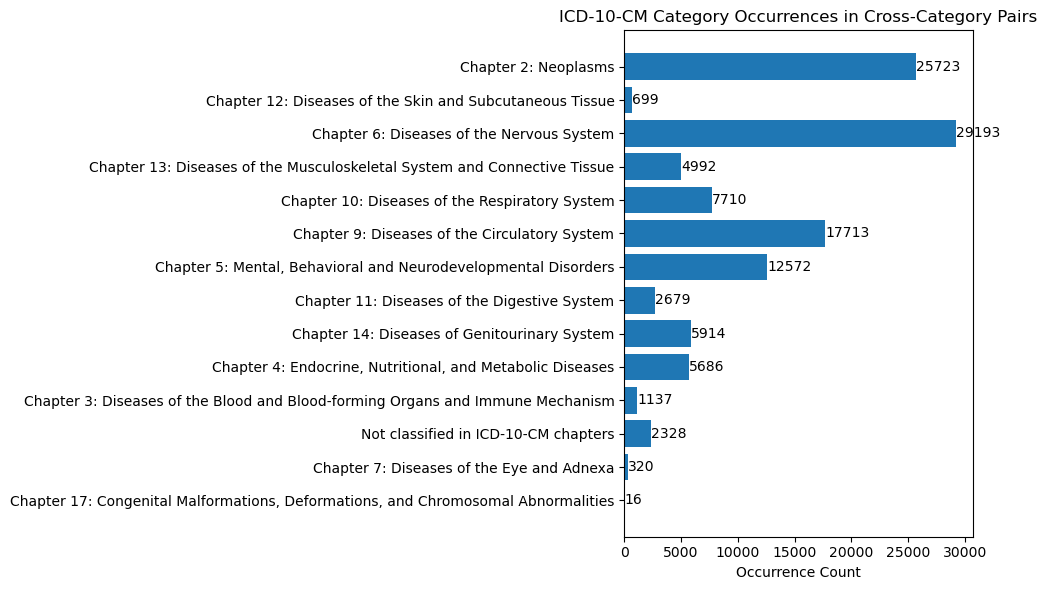

After Filtering:


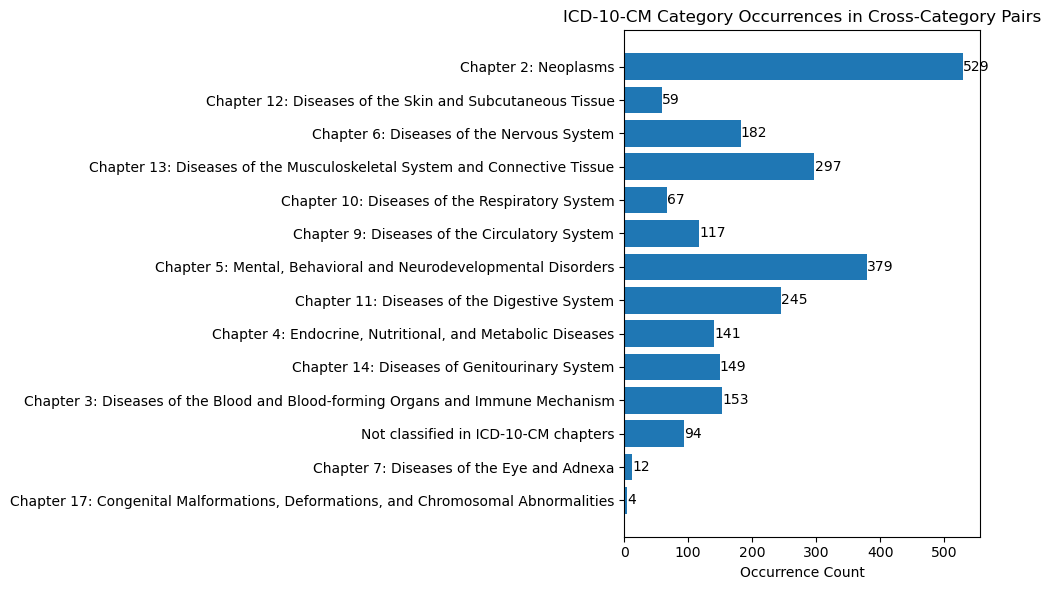

In [26]:
print('Before Filtering:')
count_category_occurrences(cutoff_005_results)
print('After Filtering:')
count_category_occurrences(different_category_results)

In [27]:
different_category_results[:3]

[{'pair1': 'Acute_Myeloid_Leukemia--Hypertension',
  'pair2': 'Alopecia--None',
  'overlap_count': 1,
  'pval_1to2': 0.0021474581133588987,
  'pval_2to1': 0.0021474581133588987,
  'shared_genes': ['A4GALT'],
  'raw_pval': 0.0021474581133588987,
  'fdr_adj_pval': 0.00657271837282235,
  'category1': 'Chapter 2: Neoplasms',
  'category2': 'Chapter 12: Diseases of the Skin and Subcutaneous Tissue'},
 {'pair1': 'Acute_Myeloid_Leukemia--Hypertension',
  'pair2': 'Alzheimers_Disease--Parkinsons_Disease',
  'overlap_count': 2,
  'pval_1to2': 1.2900388862370688e-05,
  'pval_2to1': 1.2900388862370688e-05,
  'shared_genes': ['A2ML1', 'A1BG-AS1'],
  'raw_pval': 1.2900388862370688e-05,
  'fdr_adj_pval': 8.18820286473111e-05,
  'category1': 'Chapter 2: Neoplasms',
  'category2': 'Chapter 6: Diseases of the Nervous System'},
 {'pair1': 'Acute_Myeloid_Leukemia--Hypertension',
  'pair2': 'Ankylosing_Spondylitis--None',
  'overlap_count': 3,
  'pval_1to2': 1.1987447508025614e-07,
  'pval_2to1': 1.198744